Found 15000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1340s 3s/step - accuracy: 0.5232 - loss: 0.9647 - val_accuracy: 0.7938 - val_loss: 0.5201
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1310s 3s/step - accuracy: 0.7897 - loss: 0.4939 - val_accuracy: 0.8850 - val_loss: 0.2893
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1314s 3s/step - accuracy: 0.8600 - loss: 0.3423 - val_accuracy: 0.9066 - val_loss: 0.2487
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1314s 3s/step - accuracy: 0.8951 - loss: 0.2620 - val_accuracy: 0.9222 - val_loss: 0.2044
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1311s 3s/step - accuracy: 0.9168 - loss: 0.2182 - val_accuracy: 0.9370 - val_loss: 0.1563
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1306s 3s/step - accuracy: 0.9395 - loss: 0.1572 - val_accuracy: 0.9546 - val_loss: 0.1125
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1309s 3s/step - accuracy: 0.9460 - loss: 0.1317 - val

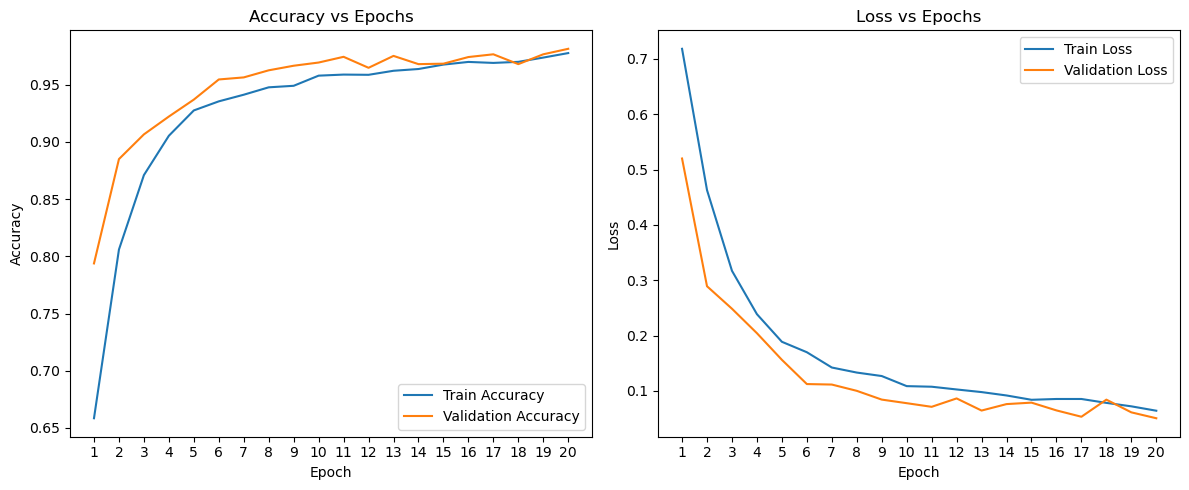

157/157 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step
Classification Report:
               precision    recall  f1-score   support

   colon_aca     0.9960    0.9940    0.9950      1000
     colon_n     0.9960    0.9990    0.9975      1000
    lung_aca     0.9204    0.9940    0.9558      1000
      lung_n     0.9980    0.9970    0.9975      1000
    lung_scc     0.9957    0.9160    0.9542      1000

    accuracy                         0.9800      5000
   macro avg     0.9812    0.9800    0.9800      5000
weighted avg     0.9812    0.9800    0.9800      5000



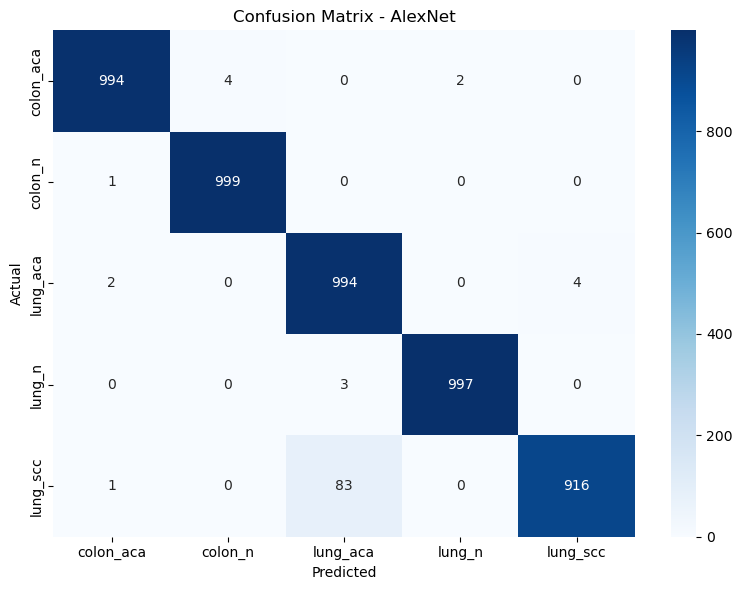

In [6]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# === Paths and Config ===
dataset_dir = 'combined_dataset1'
img_size = (227, 227)
batch_size = 32
epochs = 20

# === Data Generators with Augmentation ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'validation'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# === Save Class Indices ===
with open('class_indices_alexnet.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

# === Build AlexNet Model ===
model = Sequential([
    Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    
    Conv2D(256, (5,5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    Conv2D(384, (3,3), padding='same', activation='relu'),
    Conv2D(384, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# === Compile with Lower LR ===
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# === Callback for Saving Best Model ===
checkpoint = ModelCheckpoint('alexnet_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# === Train the Model ===
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

# === Plot Accuracy and Loss ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history.history['accuracy'], label='Train Accuracy')
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history.history['loss'], label='Train Loss')
plt.plot(range(1, epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

# === Evaluate on Test Set ===
test_generator.reset()
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# === Classification Report ===
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("Classification Report:\n", report)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - AlexNet')
plt.tight_layout()
plt.show()
